# Introduction 

## Motivation

In this tutorial, the topic of feature selection is explained on a chemical dataset containing information about the melting point (MP) of several molecules. Based on the structure of the molecule, several hundred features have been extracted, however some of them do not contain any useful information on the MP of molecules. 

When dealing with machine learning algorithms such as linear regression or decision trees for regression problems, we are eager to only use features that are important to the target variable and leave out unimportant ones, as they introduce bias to the model performance. In order to find those features that are useful to the target variable, we use several feature selection algorithms provided by the `sklearn` library. Then we train a multilinear regression model and a decision tree on both, on all features and the selected ones in order to see whether and how much the model performance has increased. 

## Feature selection

* Types of feature selction
* Advantages and disadvanteges
* Sources

# Code

## Import modules 

In [1]:
# Standard
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Base Estimator
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import OneHotEncoder

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Feature slection
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE


# Performance estimator 
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Set plotstyle for fancier plots
plt.style.use('seaborn')

## Data import

In order to import the data, we use pandas `read_csv` function. To get a sneak peak of the dataframe, we just call the `head()` method. 

In [3]:
df=pd.read_csv('data/mp_data_desc_alt.csv')
df.head(n=2)

,V1,compound,CSID,MP_Kelvin,SMILES,rdk_smiles,BalabanJ,BertzCT,Chi0,Chi0n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,0,(-)-levonorgestrel,12560,509.15,O=C4\C=C3/[C@@H]([C@H]2CC[C@]1([C@@H](CC[C@]1(...,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.671196,597.453052,16.242276,14.183525,...,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.746050
1,1,"(1E,4E)-1,5-Di(2-naphthyl)-1,4-pentadien-3-one",4523376,516.65,O=C(\C=C\c2ccc1c(cccc1)c2)\C=C\c2ccc1c(cccc1)c2,O=C(/C=C/c1ccc2ccccc2c1)/C=C/c1ccc2ccccc2c1,1.489886,1057.599472,17.769374,14.300553,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.400873


As there are some columns that we do not need for further research, we use the `drop()` method in order to get rid of them. Remebmer to set `axis=1` to drop actual columns, as the default `axis=0` drops rows. 

In [4]:
dataset_clean = df.drop(['V1', 'compound', 'CSID', 'SMILES', 'rdk_smiles'], axis=1)
dataset_clean.head()

,MP_Kelvin,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,509.15,1.671196,597.453052,16.242276,14.183525,14.183525,11.043772,9.478974,9.478974,8.395266,...,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.746050
1,516.65,1.489886,1057.599472,17.769374,14.300553,14.300553,12.775990,8.656260,8.656260,6.282212,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.400873
2,360.90,2.181267,541.858095,12.087576,9.206315,9.206315,8.270857,5.326448,5.326448,3.625417,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.641274
3,461.15,2.258880,691.777798,14.535169,10.392675,10.392675,9.575387,5.825887,5.825887,4.063838,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.399765
4,463.15,2.084842,580.396040,13.664926,10.537213,10.537213,9.185872,5.843521,5.843521,4.017618,...,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea,0.672316


## Preprocessing
In this step we are going to split the dataset into target column (`MP_Kelvin`), columns with numerical features and columns containing categorical features. The reason why we are doing this is that we have to treat numerical features differently from categorical ones. For the former, we are going to apply a `MinMaxScaler` to scale them all in a range from 0 and 1 to make them comparable. Otherwise, a feature having a larger scale will bias the model as it will have a higher influence on the target due to its value range regardless of the information it is containing. For the latter features (categorical) we are going to apply the `get_dummies` function of `pandas` in order to make them applicable to any model. In the last step, the three datasets will be merged together again. 

### Splitting base dataset
First of all, we get the target column `MP_Kelvin` by simple subsetting.

In [5]:
target = dataset_clean[['MP_Kelvin']]

Next we are going to apply list comprehension to identify all categorical features starting with 'fr_' and then print them. Having a list of the categorical feature names allows us to subset the dataset once again, leaving us with a dataframe containing only categorical features

In [6]:
feat_categorical = [col for col in dataset_clean.columns if 'fr_' in col]
print(feat_categorical)

['fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos

In [7]:
categorical = dataset_clean[feat_categorical]
categorical.head()

,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0xfr_Al_COO,1xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,0xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,1xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
1,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,0xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
2,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
3,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea
4,0xfr_Al_COO,0xfr_Al_OH,0xfr_Al_OH_noTert,0xfr_ArN,0xfr_Ar_COO,0xfr_Ar_N,0xfr_Ar_NH,1xfr_Ar_OH,0xfr_COO,0xfr_COO2,...,0xfr_sulfide,0xfr_sulfonamd,0xfr_sulfone,0xfr_term_acetylene,0xfr_tetrazole,0xfr_thiazole,0xfr_thiocyan,0xfr_thiophene,0xfr_unbrch_alkane,0xfr_urea


Last but not least, we create a dataframe containing only numerical features using again a list comprehensions.

In [8]:
feat_numeric = [col for col in dataset_clean.columns if 'fr_' not in col and 'MP_Kelvin' not in col]

In [9]:
numerical = dataset_clean[feat_numeric]
numerical.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,qed
0,1.671196,597.453052,16.242276,14.183525,14.183525,11.043772,9.478974,9.478974,8.395266,8.395266,...,0.0,0,0,0,0,0,0,0.0,48.166667,0.746050
1,1.489886,1057.599472,17.769374,14.300553,14.300553,12.775990,8.656260,8.656260,6.282212,6.282212,...,0.0,0,0,0,0,0,0,0.0,54.666667,0.400873
2,2.181267,541.858095,12.087576,9.206315,9.206315,8.270857,5.326448,5.326448,3.625417,3.625417,...,0.0,0,0,0,0,0,0,0.0,41.666667,0.641274
3,2.258880,691.777798,14.535169,10.392675,10.392675,9.575387,5.825887,5.825887,4.063838,4.063838,...,0.0,0,0,0,0,0,0,0.0,57.333333,0.399765
4,2.084842,580.396040,13.664926,10.537213,10.537213,9.185872,5.843521,5.843521,4.017618,4.017618,...,0.0,0,0,0,0,0,0,0.0,46.833333,0.672316


### Min-Max Scaling 

First of all we apply the `MinMaxScaler` to the dataframe `numerical`. We do that by first creating an object called `myScaler` and then doing `fit_transform` on our dataset. 

In [10]:
class BaseScaler(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator=estimator
        
    def fit(self, X, y=None):
        self.estimator.fit(X)
        
    def tranform(self, X, y=None):
        self.estimator.tranform(X)

In [11]:
myScaler = MinMaxScaler()

In [12]:
colnames = numerical.columns
numerical_scaled = pd.DataFrame(myScaler.fit_transform(numerical), index=None, columns=colnames)
numerical_scaled.head()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,qed
0,0.353975,0.262001,0.361420,0.402567,0.402567,0.377277,0.463002,0.463002,0.483764,0.483764,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.357444,0.763265
1,0.315571,0.463789,0.395400,0.405888,0.405888,0.436453,0.422817,0.422817,0.362003,0.362003,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.394624,0.335751
2,0.462012,0.237621,0.268970,0.261300,0.261300,0.282549,0.260171,0.260171,0.208909,0.208909,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.320263,0.633496
3,0.478451,0.303365,0.323433,0.294972,0.294972,0.327114,0.284566,0.284566,0.234172,0.234172,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.409878,0.334379
4,0.441589,0.254521,0.304069,0.299074,0.299074,0.313808,0.285428,0.285428,0.231509,0.231509,...,0.07832,0.0,0.0,0.0,0.0,0.0,0.0,0.046602,0.349817,0.671942


### One-Hot-Encoding
In this step we are tranforming the categorical features into 

In [13]:
#encoder = OneHotEncoder(categorical_features = 'all')

In [14]:
categorical_encoded = pd.get_dummies(categorical, prefix='')
categorical_encoded.head()

,_0xfr_Al_COO,_1xfr_Al_COO,_2xfr_Al_COO,_3xfr_Al_COO,_0xfr_Al_OH,_1xfr_Al_OH,_2xfr_Al_OH,_3xfr_Al_OH,_4xfr_Al_OH,_5xfr_Al_OH,...,_1xfr_unbrch_alkane,_2xfr_unbrch_alkane,_3xfr_unbrch_alkane,_4xfr_unbrch_alkane,_5xfr_unbrch_alkane,_6xfr_unbrch_alkane,_7xfr_unbrch_alkane,_9xfr_unbrch_alkane,_0xfr_urea,_1xfr_urea
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Creating final preprocessed dataset

In [15]:
dataset_processed = pd.concat([target, numerical_scaled, categorical_encoded], axis = 1)
dataset_processed.head()

,MP_Kelvin,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,...,_1xfr_unbrch_alkane,_2xfr_unbrch_alkane,_3xfr_unbrch_alkane,_4xfr_unbrch_alkane,_5xfr_unbrch_alkane,_6xfr_unbrch_alkane,_7xfr_unbrch_alkane,_9xfr_unbrch_alkane,_0xfr_urea,_1xfr_urea
0,509.15,0.353975,0.262001,0.361420,0.402567,0.402567,0.377277,0.463002,0.463002,0.483764,...,0,0,0,0,0,0,0,0,1,0
1,516.65,0.315571,0.463789,0.395400,0.405888,0.405888,0.436453,0.422817,0.422817,0.362003,...,0,0,0,0,0,0,0,0,1,0
2,360.90,0.462012,0.237621,0.268970,0.261300,0.261300,0.282549,0.260171,0.260171,0.208909,...,0,0,0,0,0,0,0,0,1,0
3,461.15,0.478451,0.303365,0.323433,0.294972,0.294972,0.327114,0.284566,0.284566,0.234172,...,0,0,0,0,0,0,0,0,1,0
4,463.15,0.441589,0.254521,0.304069,0.299074,0.299074,0.313808,0.285428,0.285428,0.231509,...,0,0,0,0,0,0,0,0,1,0


### Create Train and test set

First of all we should create a train and a test set, as feature selection should only be used on the train set. 

In [16]:
X = dataset_processed.drop('MP_Kelvin', axis = 1)
y = dataset_processed[['MP_Kelvin']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Selection

In this step, we apply two different feature selection algorithms on the previously created train set. First of all, a univariate filter algorithm based on the **mutual information** between a feature and the target is applied. Then, we also apply a wrapper method called **Recursive Feature Elimination** based on a **Random Forest model**

### Mutual Information

TODO: Info on mutual information

/home/kubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


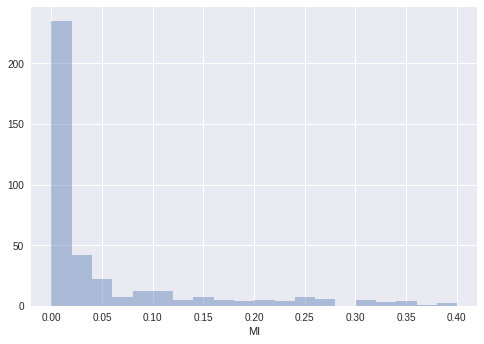

In [18]:
mreg = mutual_info_regression(X_train, y_train)
fs_results = pd.DataFrame(data = mreg, index = X_train.columns, columns=['MI'])
sns.distplot(fs_results['MI'], bins = 20, kde=False)

In [19]:
important_features_mi = fs_results[(fs_results.T >=0.1).any()].index
important_features_mi

Index(['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n',
       'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
       'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA8', 'ExactMolWt', 'FractionCSP3',
       'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Kappa1', 'Kappa2',
       'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge',
       'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex',
       'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP',
       'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAromaticCarbocycles',
       'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
       'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA3', 'PEOE_VSA7',
       'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3',
       'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3',
       'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8

### Recursive Feature Elimination

In [20]:
estimator = RandomForestRegressor()
selector = RFE(estimator, 60, step=1)
selector.fit(X_train, y_train)

/home/kubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
  n_features_to_select=60, step=1, verbose=0)

In [21]:
important_features_rfe = X.T[selector.get_support()].index
important_features_rfe

Index(['BalabanJ', 'BertzCT', 'Chi0', 'Chi1', 'Chi1n', 'Chi2n', 'Chi2v',
       'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
       'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2',
       'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomMolWt',
       'Kappa1', 'Kappa2', 'Kappa3', 'MaxAbsPartialCharge', 'MaxEStateIndex',
       'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge',
       'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'NHOHCount',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'PEOE_VSA1',
       'PEOE_VSA12', 'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8',
       'PEOE_VSA9', 'RingCount', 'SMR_VSA10', 'SMR_VSA5', 'SMR_VSA7',
       'SMR_VSA9', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6',
       'SlogP_VSA8', 'TPSA', 'VSA_EState9', 'qed'],
      dtype='object')

## Regression models

In [134]:
from collections import defaultdict
def compare_feature_selection(models, X_train, X_test, y_train, y_test, feat_sel):
    results_model = []
    names_model   = []
    
    for name, model in models:
        results_fs = defaultdict(list)
        for key in feat_sel:
            # Get features
            features = feat_sel[key]

            # fit model
            error = fit_regression_model(model, X_train[features], X_test[features], y_train, y_test)
            
            # Add results
            results_fs[key].append(error)
        
        results_model.append(pd.DataFrame(results_fs))
        names_model.append(name)
        
    df_final = pd.concat(results_model, axis=0).T
    df_final.columns = names_model
    return df_final

In [136]:
def fit_regression_model(model, X_train, X_test, y_train, y_test):
    from math import sqrt
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return sqrt(mean_squared_error(y_test, pred))

In [154]:
from sklearn.svm import LinearSVR

In [155]:
model_list = [("LR", LinearRegression()), ("DT", DecisionTreeRegressor(random_state=44)), ("RF", RandomForestRegressor()), ("SVM", LinearSVR())]
feat_dict = {
    "No Feature Selection":X.columns,
    "Mutual Information":important_features_mi, 
    "Random Forest-RFE": important_features_rfe
}

In [156]:
results = compare_feature_selection(model_list, X_train, X_test, y_train, y_test, feat_dict)

/home/kubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/kubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/kubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/kubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [163]:
results

,LR,DT,RF,SVM
Mutual Information,6.283586e+01,75.639883,55.251004,71.398675
No Feature Selection,7.082665e+13,64.885859,53.267866,61.824657
Random Forest-RFE,6.008070e+01,69.386574,56.355245,71.561351


In [196]:
x =results.index.tolist() + results.columns.tolist()

In [197]:
df_ = pd.melt(results, value_vars=x)

/home/kubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/home/kubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [198]:
df_

,variable,value
0,Mutual Information,NaN
1,Mutual Information,NaN
2,Mutual Information,NaN
3,No Feature Selection,NaN
4,No Feature Selection,NaN
5,No Feature Selection,NaN
6,Random Forest-RFE,NaN
7,Random Forest-RFE,NaN
8,Random Forest-RFE,NaN
9,LR,6.283586e+01


In [ ]:
sns.barplot(data = df_, x = "variable")